# Bed Frame Movement Analysis - Velocity Profiles

This notebook focuses on analyzing bed frame movements and visualizing velocity profiles to understand stop delays.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Import our custom modules
from movement_detection import MovementConfig, calculate_velocity
from ha_client import load_ha_events
from bed_frame_analysis import load_sensor_data, analyze_interrupted_events

%matplotlib inline

# Set default figure size for better visibility
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Configuration
DATASET = 'partial-movements.csv'  # Change to 'open-close.csv' for full movement analysis
ENTITY_ID = 'cover.bed_remote_head_position'
HA_URL = 'http://tvpi:8123'
TOKEN_PATH = '/run/secrets/home-assistant/token'

# Movement detection parameters
config = MovementConfig(
    window_seconds=20.0,
    movement_threshold=0.005,      # rad/s to consider as stopped
    stability_time=0.5,             # seconds of stability required
    start_movement_threshold=0.01  # minimum change to detect movement start
)

print(f"Dataset: {DATASET}")
print(f"Movement threshold: {config.movement_threshold:.3f} rad/s")
print(f"Stability time: {config.stability_time:.1f} s")

Dataset: partial-movements.csv
Movement threshold: 0.005 rad/s
Stability time: 0.5 s


In [3]:
# Load sensor data and Home Assistant events
df = load_sensor_data(DATASET)
ha_events = load_ha_events(df, ENTITY_ID, HA_URL, TOKEN_PATH, event_types=None)

print(f"Loaded {len(df)} sensor readings")
print(f"Time range: {df['sensor_timestamp'].min().strftime('%H:%M:%S')} to {df['sensor_timestamp'].max().strftime('%H:%M:%S')}")
print(f"Pitch range: {df['pitch'].min():.3f} to {df['pitch'].max():.3f} rad")
print(f"\nFound {len(ha_events)} events:")

# Group events by type
event_counts = {}
for event in ha_events:
    state = event['state']
    event_counts[state] = event_counts.get(state, 0) + 1
    
for state, count in sorted(event_counts.items()):
    print(f"  {state}: {count}")

Loaded 1260 sensor readings
Time range: 23:49:33 to 23:50:36
Pitch range: 0.043 to 0.564 rad

Found 20 events:
  closed: 1
  closing: 5
  open: 9
  opening: 5


In [4]:
# Analyze movements to find response times and stop delays
analysis = analyze_interrupted_events(ha_events, df, config)

if analysis['results']:
    print(f"Analyzed {len(analysis['results'])} movement→stop sequences\n")
    
    # Summary by movement type
    for result in analysis['results']:
        print(f"{result.movement_type.capitalize()}: "
              f"{result.movement_command_time.strftime('%H:%M:%S')} → "
              f"{result.stop_command_time.strftime('%H:%M:%S')} "
              f"(response: {result.start_delay_ms:.0f}ms, stop: {result.stop_delay_ms:.0f}ms)")
    
    # Statistics
    if analysis['statistics']:
        print("\n" + "="*50)
        for movement_type, stats in analysis['statistics'].items():
            print(f"{movement_type.replace('_', ' ').title()}:")
            print(f"  Average response time: {stats.get('avg_start_delay_ms', 0):.0f} ms")
            print(f"  Average stop delay: {stats['avg_stop_delay_ms']:.0f} ms")
            print(f"  Stop delay range: {stats['min_stop_delay_ms']:.0f}-{stats['max_stop_delay_ms']:.0f} ms")
else:
    print("No movement sequences found in data")

Analyzed 10 movement→stop sequences

Opening: 23:49:51 → 23:49:55 (response: 1831ms, stop: 340ms)
Opening: 23:50:00 → 23:50:03 (response: 84ms, stop: 331ms)
Opening: 23:50:06 → 23:50:08 (response: 94ms, stop: 322ms)
Closing: 23:50:11 → 23:50:12 (response: 95ms, stop: 324ms)
Closing: 23:50:14 → 23:50:14 (response: 91ms, stop: 318ms)
Closing: 23:50:15 → 23:50:16 (response: 59ms, stop: 324ms)
Opening: 23:50:18 → 23:50:19 (response: 96ms, stop: 289ms)
Opening: 23:50:20 → 23:50:21 (response: 58ms, stop: 329ms)
Closing: 23:50:22 → 23:50:23 (response: 68ms, stop: 414ms)
Closing: 23:50:24 → 23:50:30 (response: 97ms, stop: 275ms)

Opening Interrupted:
  Average response time: 433 ms
  Average stop delay: 322 ms
  Stop delay range: 289-340 ms
Closing Interrupted:
  Average response time: 82 ms
  Average stop delay: 331 ms
  Stop delay range: 275-414 ms


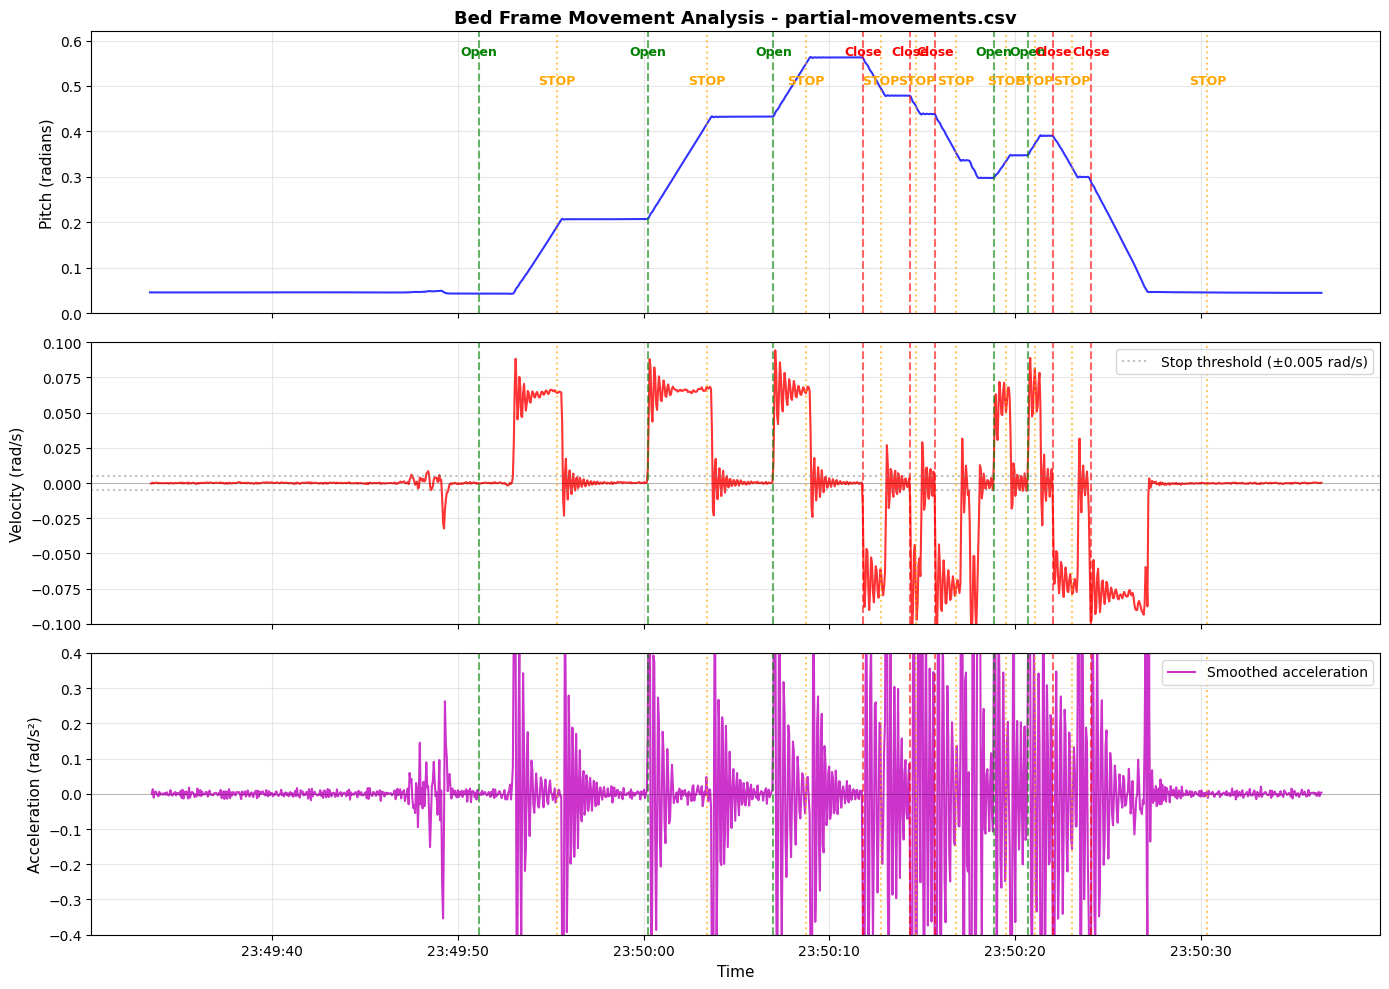

Green = Opening command, Red = Closing command, Orange = Stop command
Positive velocity = bed opening (pitch increasing)
Negative velocity = bed closing (pitch decreasing)
Positive acceleration = speeding up in current direction
Negative acceleration = slowing down in current direction


In [5]:
# Main visualization: Pitch, velocity, and acceleration over time with all events
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Calculate velocity and acceleration for entire dataset
df_with_velocity = calculate_velocity(df)

# Plot pitch
ax1.plot(df['sensor_timestamp'], df['pitch'], 'b-', linewidth=1.5, alpha=0.8)
ax1.set_ylabel('Pitch (radians)', fontsize=11)
ax1.set_ylim(0, df['pitch'].max() * 1.1)  # 0 to max with 10% padding
ax1.grid(True, alpha=0.3)
ax1.set_title(f'Bed Frame Movement Analysis - {DATASET}', fontsize=13, fontweight='bold')

# Plot velocity (signed: positive=opening, negative=closing)
ax2.plot(df_with_velocity['sensor_timestamp'], df_with_velocity['pitch_velocity_signed_smooth'], 
         'r-', linewidth=1.5, alpha=0.8)
ax2.axhline(y=config.movement_threshold, color='gray', linestyle=':', alpha=0.5, 
            label=f'Stop threshold (±{config.movement_threshold:.3f} rad/s)')
ax2.axhline(y=-config.movement_threshold, color='gray', linestyle=':', alpha=0.5)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
ax2.set_ylabel('Velocity (rad/s)', fontsize=11)
ax2.set_ylim(-0.1, 0.1)  # Fixed range for velocity
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right')

# Plot acceleration (signed)
ax3.plot(df_with_velocity['sensor_timestamp'], df_with_velocity['pitch_acceleration_smooth'], 
         'm-', linewidth=1.5, alpha=0.8, label='Smoothed acceleration')
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
ax3.set_ylabel('Acceleration (rad/s²)', fontsize=11)
ax3.set_ylim(-0.4, 0.4)  # Fixed range for acceleration
ax3.set_xlabel('Time', fontsize=11)
ax3.grid(True, alpha=0.3)
ax3.legend(loc='upper right')

# Add event markers to all plots
for event in ha_events:
    if event['state'] in ['opening', 'closing']:
        color = 'green' if event['state'] == 'opening' else 'red'
        label = 'Open' if event['state'] == 'opening' else 'Close'
        for ax in [ax1, ax2, ax3]:
            ax.axvline(x=event['timestamp'], color=color, linestyle='--', 
                      alpha=0.6, linewidth=1.5)
            # Add label only on top plot
            if ax == ax1:
                ax.text(event['timestamp'], ax.get_ylim()[1]*0.95, label,
                       rotation=0, ha='center', va='top', color=color, 
                       fontsize=9, fontweight='bold')
    
    elif event['state'] in ['open', 'closed']:
        color = 'orange'
        for ax in [ax1, ax2, ax3]:
            ax.axvline(x=event['timestamp'], color=color, linestyle=':', 
                      alpha=0.6, linewidth=1.5)
            # Add label only on top plot
            if ax == ax1:
                ax.text(event['timestamp'], ax.get_ylim()[1]*0.85, 'STOP',
                       rotation=0, ha='center', va='top', color=color, 
                       fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("Green = Opening command, Red = Closing command, Orange = Stop command")
print("Positive velocity = bed opening (pitch increasing)")
print("Negative velocity = bed closing (pitch decreasing)")
print("Positive acceleration = speeding up in current direction")
print("Negative acceleration = slowing down in current direction")

Showing movement profiles for 10 sequences:



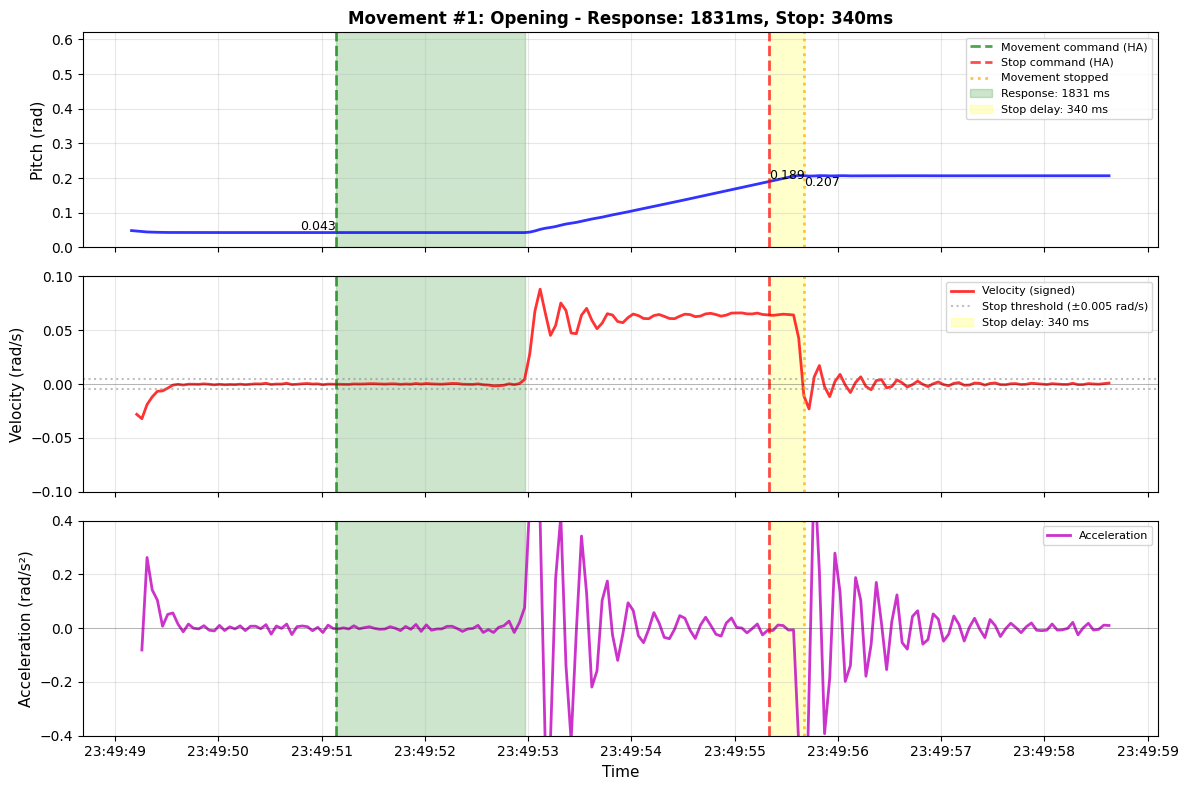

Movement #1 Details:
  Type: opening
  Command duration: 4.20 seconds
  Response delay: 1831 ms (movement detected in sensor)
  Stop delay: 340 ms
  Pitch change: 0.146 rad
  Overrun after stop: 0.015 rad
  Velocity at stop command: 0.064 rad/s



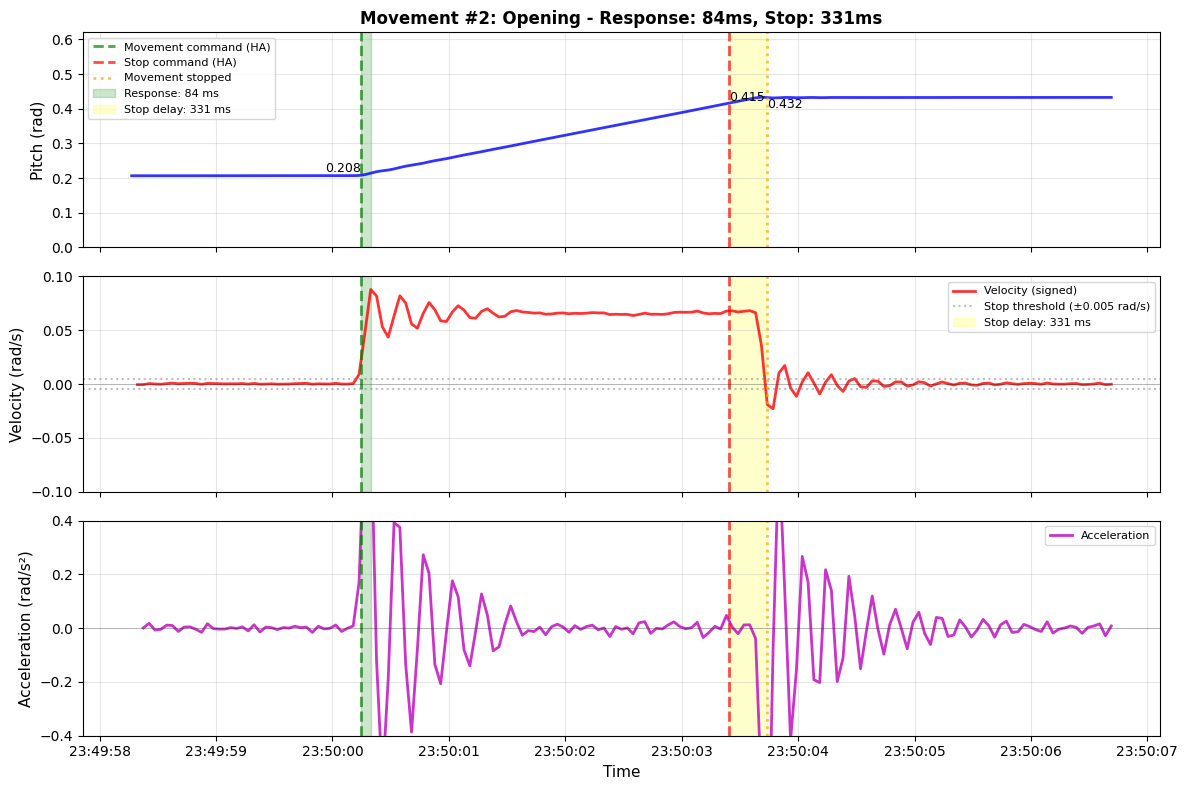

Movement #2 Details:
  Type: opening
  Command duration: 3.16 seconds
  Response delay: 84 ms (movement detected in sensor)
  Stop delay: 331 ms
  Pitch change: 0.207 rad
  Overrun after stop: 0.014 rad
  Velocity at stop command: 0.068 rad/s



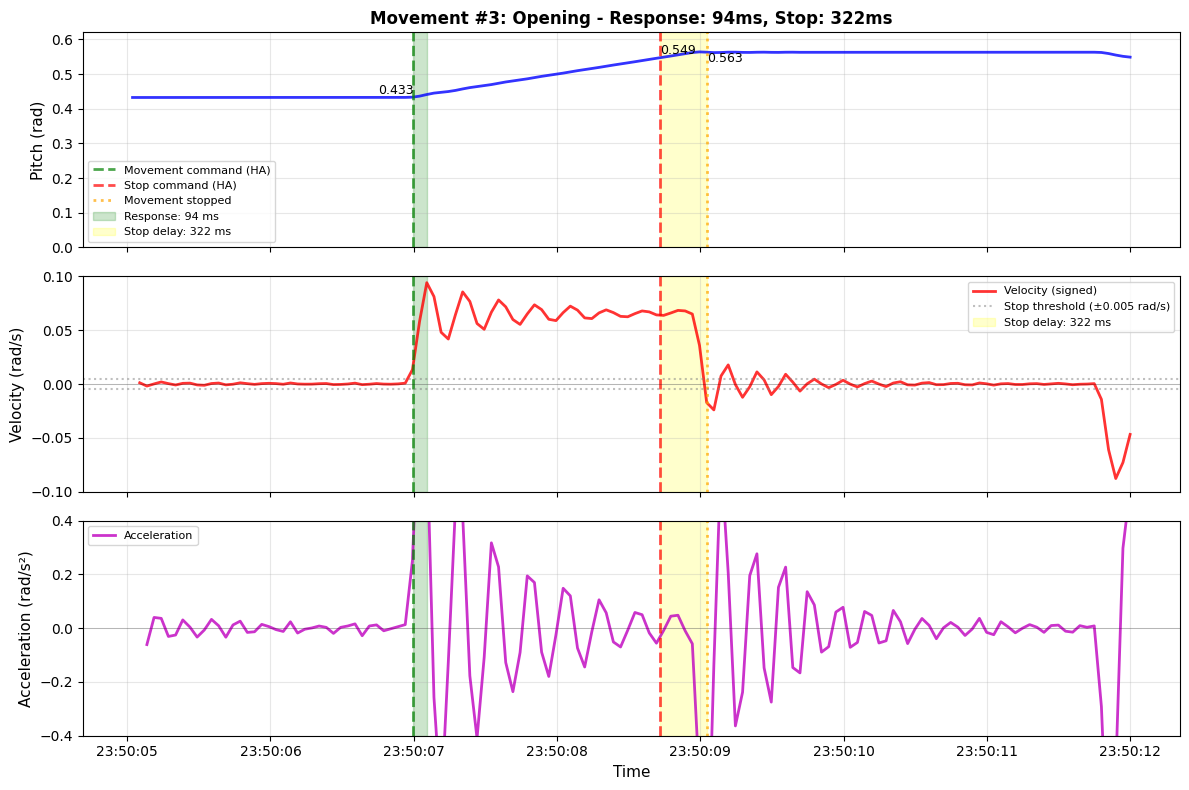

Movement #3 Details:
  Type: opening
  Command duration: 1.73 seconds
  Response delay: 94 ms (movement detected in sensor)
  Stop delay: 322 ms
  Pitch change: 0.115 rad
  Overrun after stop: 0.014 rad
  Velocity at stop command: 0.064 rad/s



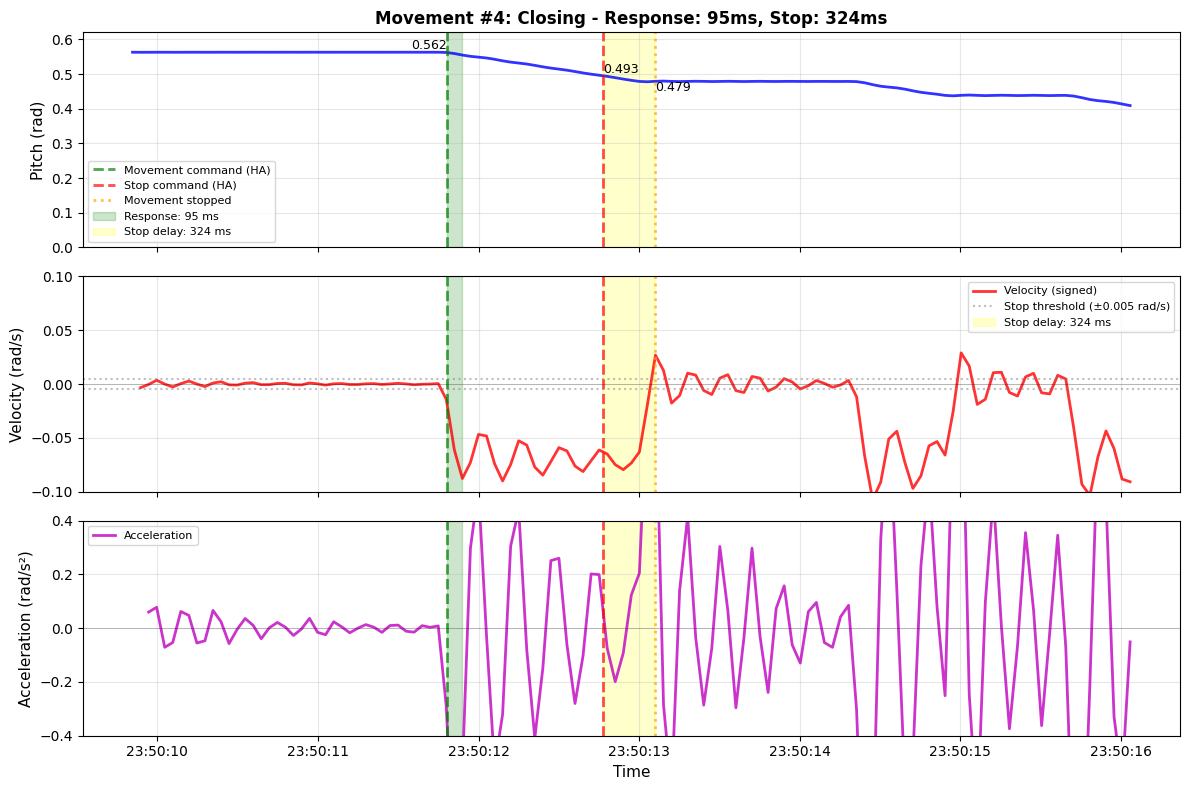

Movement #4 Details:
  Type: closing
  Command duration: 0.97 seconds
  Response delay: 95 ms (movement detected in sensor)
  Stop delay: 324 ms
  Pitch change: -0.069 rad
  Overrun after stop: -0.014 rad
  Velocity at stop command: 0.065 rad/s



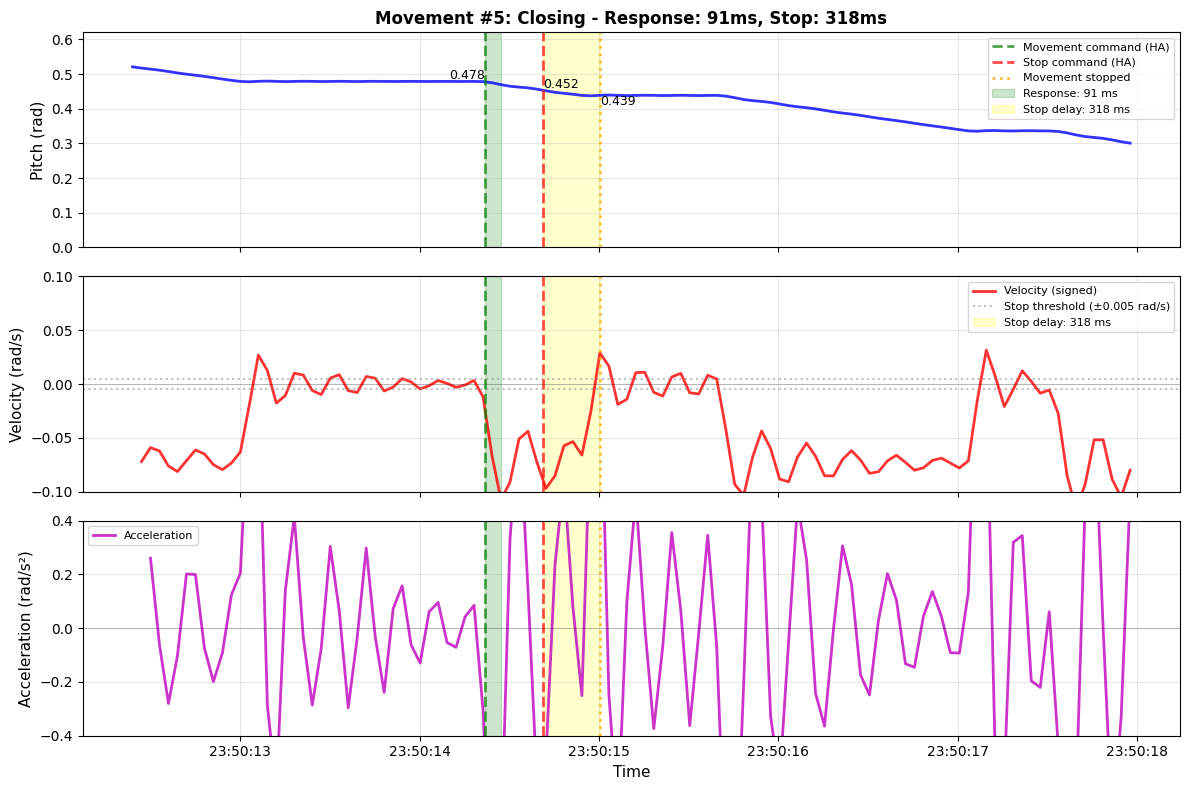

Movement #5 Details:
  Type: closing
  Command duration: 0.32 seconds
  Response delay: 91 ms (movement detected in sensor)
  Stop delay: 318 ms
  Pitch change: -0.027 rad
  Overrun after stop: -0.013 rad
  Velocity at stop command: 0.097 rad/s



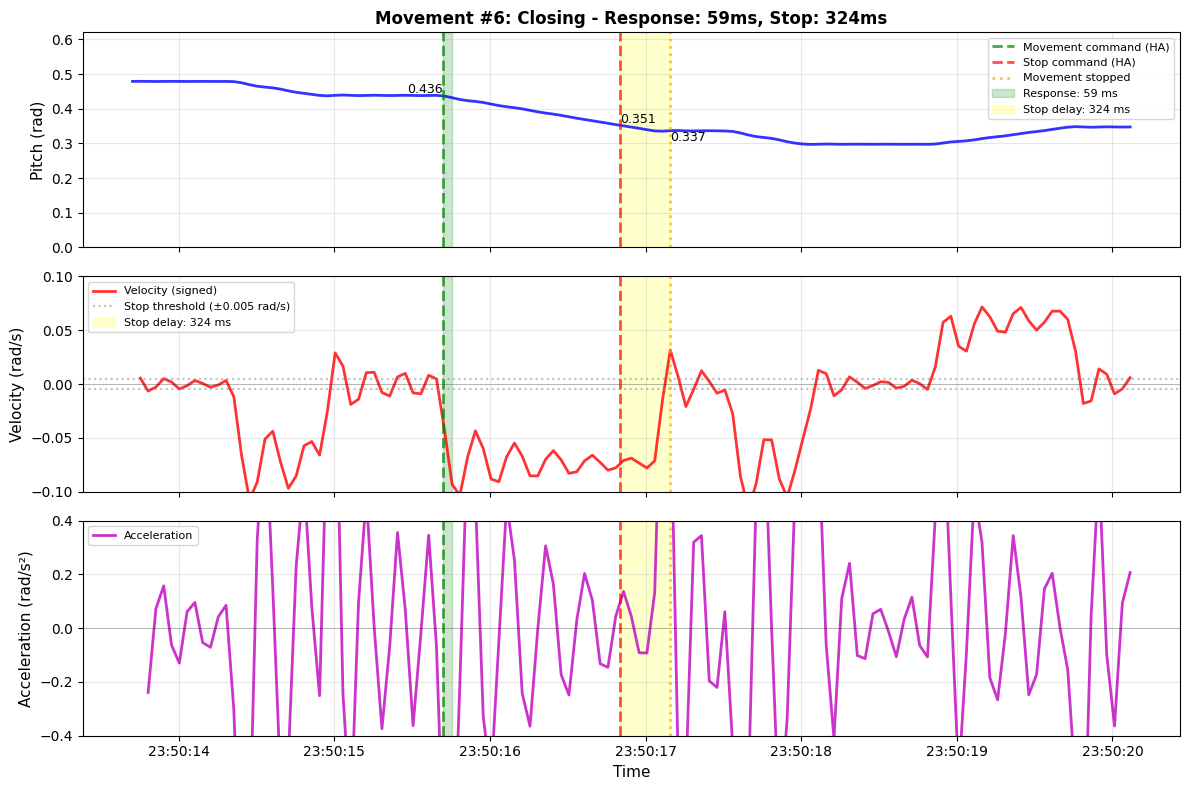

Movement #6 Details:
  Type: closing
  Command duration: 1.14 seconds
  Response delay: 59 ms (movement detected in sensor)
  Stop delay: 324 ms
  Pitch change: -0.086 rad
  Overrun after stop: -0.014 rad
  Velocity at stop command: 0.071 rad/s



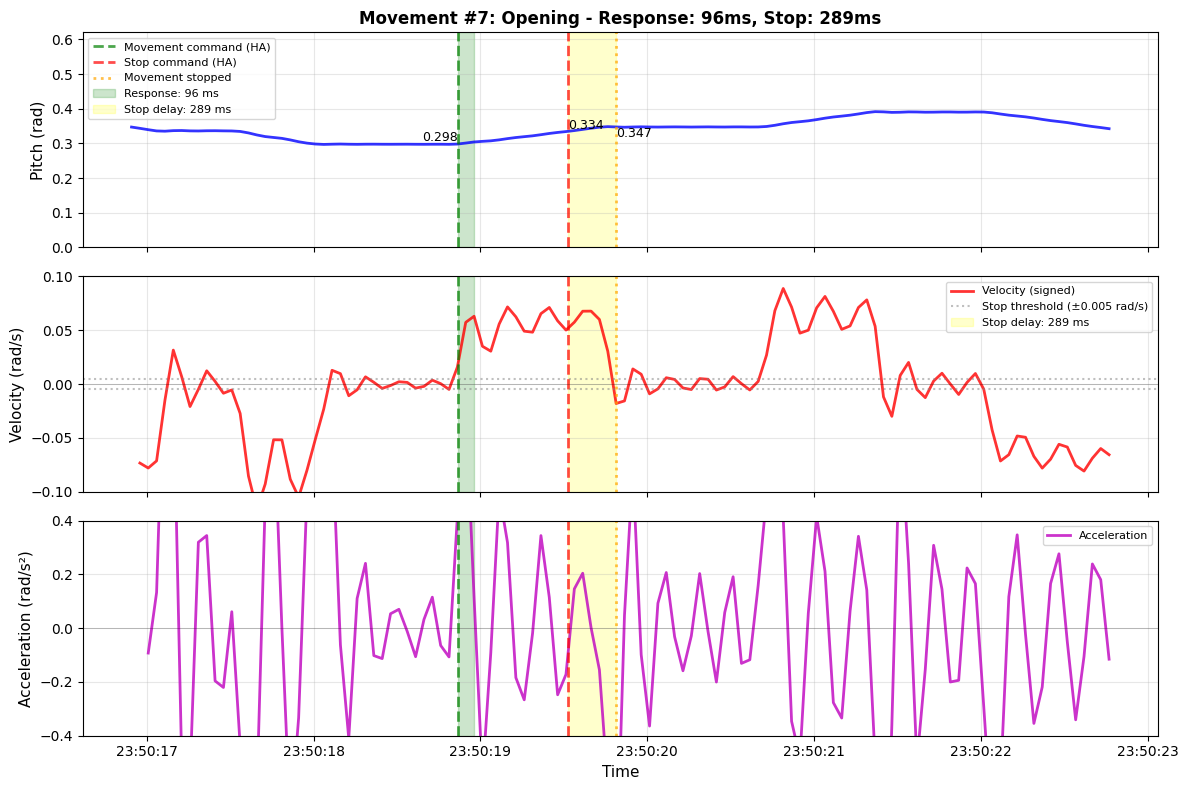

Movement #7 Details:
  Type: opening
  Command duration: 0.66 seconds
  Response delay: 96 ms (movement detected in sensor)
  Stop delay: 289 ms
  Pitch change: 0.036 rad
  Overrun after stop: 0.010 rad
  Velocity at stop command: 0.050 rad/s



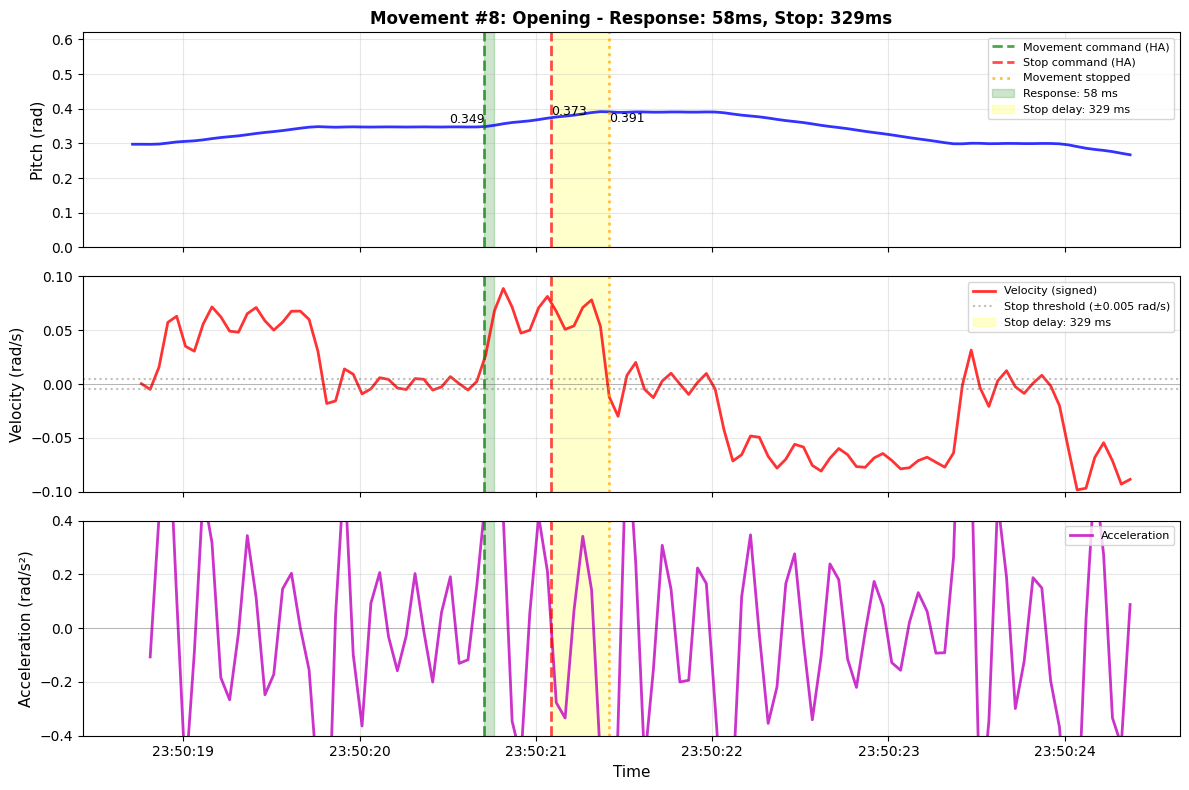

Movement #8 Details:
  Type: opening
  Command duration: 0.38 seconds
  Response delay: 58 ms (movement detected in sensor)
  Stop delay: 329 ms
  Pitch change: 0.024 rad
  Overrun after stop: 0.015 rad
  Velocity at stop command: 0.081 rad/s



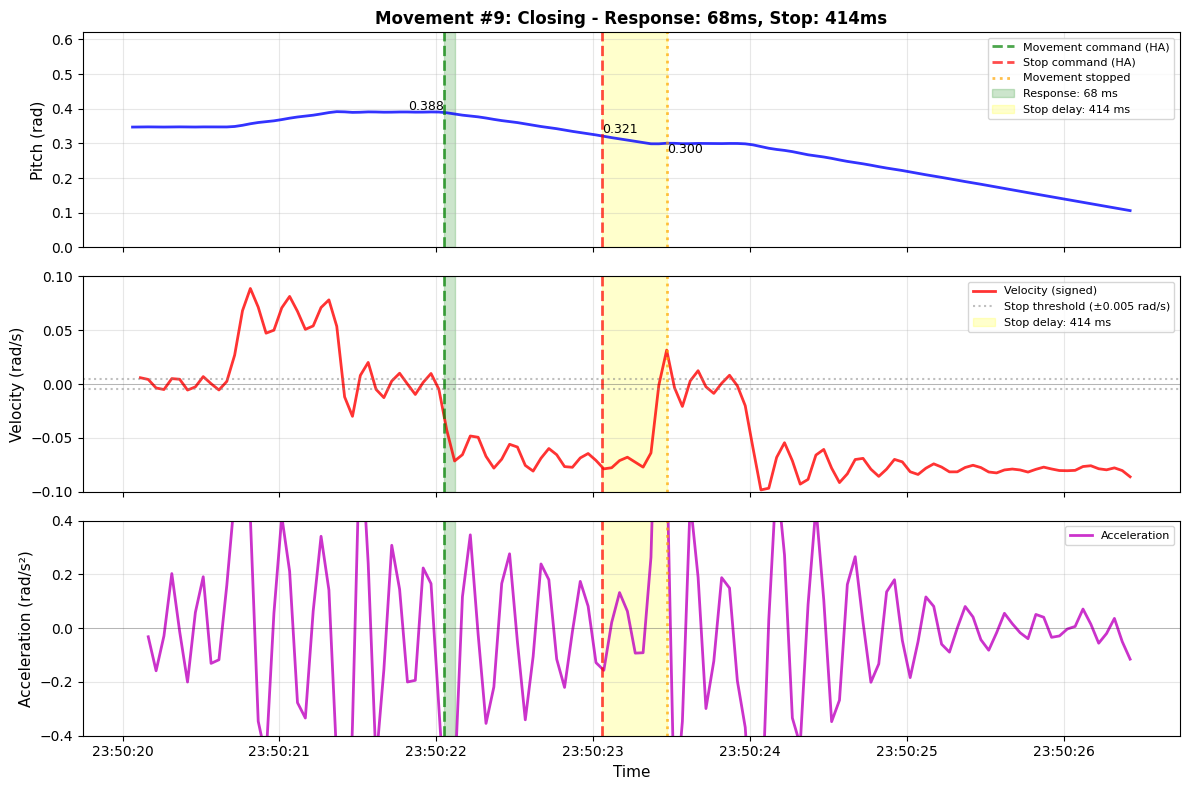

Movement #9 Details:
  Type: closing
  Command duration: 1.01 seconds
  Response delay: 68 ms (movement detected in sensor)
  Stop delay: 414 ms
  Pitch change: -0.068 rad
  Overrun after stop: -0.020 rad
  Velocity at stop command: 0.079 rad/s



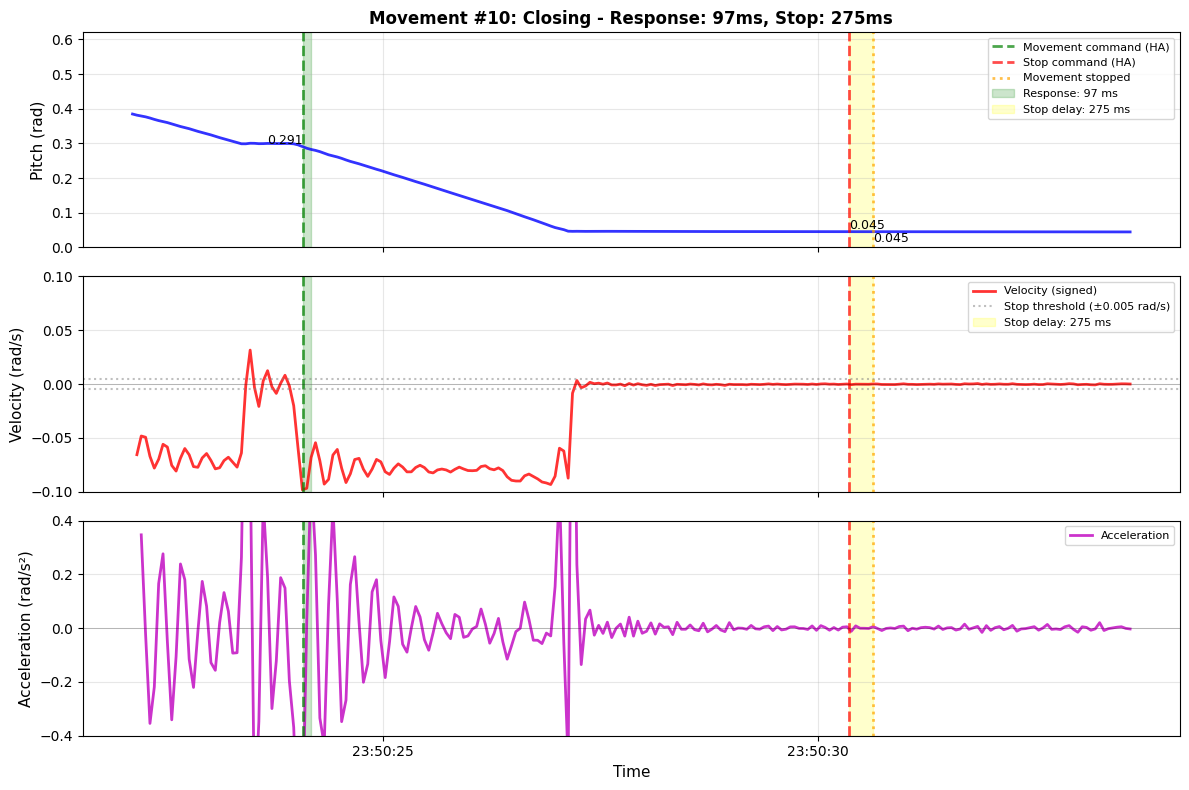

Movement #10 Details:
  Type: closing
  Command duration: 6.28 seconds
  Response delay: 97 ms (movement detected in sensor)
  Stop delay: 275 ms
  Pitch change: -0.245 rad
  Overrun after stop: -0.000 rad
  Velocity at stop command: 0.001 rad/s



In [6]:
# Detailed velocity and acceleration profiles for each movement sequence
if analysis['results']:
    print(f"Showing movement profiles for {len(analysis['results'])} sequences:\n")
    
    # Get the maximum pitch value across all data for consistent scaling
    max_pitch = df['pitch'].max()
    
    for i, result in enumerate(analysis['results'], 1):
        # Create window around this movement
        window_start = result.movement_command_time - pd.Timedelta(seconds=2)
        window_end = result.actual_stop_time + pd.Timedelta(seconds=3)
        window_df = df[(df['sensor_timestamp'] >= window_start) & 
                       (df['sensor_timestamp'] <= window_end)].copy()
        
        if len(window_df) > 10:
            window_df = calculate_velocity(window_df)
            
            # Create subplot with 3 panels
            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
            
            # Plot pitch with fixed range
            ax1.plot(window_df['sensor_timestamp'], window_df['pitch'], 
                    'b-', linewidth=2, alpha=0.8)
            ax1.set_ylabel('Pitch (rad)', fontsize=11)
            ax1.set_ylim(0, max_pitch * 1.1)  # Consistent range for all plots
            ax1.grid(True, alpha=0.3)
            ax1.set_title(f'Movement #{i}: {result.movement_type.capitalize()} - Response: {result.start_delay_ms:.0f}ms, Stop: {result.stop_delay_ms:.0f}ms', 
                         fontsize=12, fontweight='bold')
            
            # Mark key points on pitch plot
            ax1.axvline(result.movement_command_time, color='green', linestyle='--', 
                       alpha=0.7, linewidth=2, label='Movement command (HA)')
            ax1.axvline(result.stop_command_time, color='red', linestyle='--', 
                       alpha=0.7, linewidth=2, label='Stop command (HA)')
            ax1.axvline(result.actual_stop_time, color='orange', linestyle=':', 
                       alpha=0.7, linewidth=2, label='Movement stopped')
            
            # Add pitch values at key points
            ax1.text(result.movement_command_time, result.pitch_at_start, 
                    f'{result.pitch_at_start:.3f}', ha='right', va='bottom', fontsize=9)
            ax1.text(result.stop_command_time, result.pitch_at_stop_command, 
                    f'{result.pitch_at_stop_command:.3f}', ha='left', va='bottom', fontsize=9)
            ax1.text(result.actual_stop_time, result.pitch_at_actual_stop, 
                    f'{result.pitch_at_actual_stop:.3f}', ha='left', va='top', fontsize=9)
            
            # Highlight response delay period (from command to movement detected)
            # Calculate when movement was detected
            movement_detected_time = result.movement_command_time + pd.Timedelta(milliseconds=result.start_delay_ms)
            ax1.axvspan(result.movement_command_time, movement_detected_time,
                       alpha=0.2, color='green', label=f'Response: {result.start_delay_ms:.0f} ms')
            
            # Highlight stop delay period
            ax1.axvspan(result.stop_command_time, result.actual_stop_time, 
                       alpha=0.2, color='yellow', label=f'Stop delay: {result.stop_delay_ms:.0f} ms')
            
            ax1.legend(loc='best', fontsize=8)
            
            # Plot signed velocity with fixed range
            ax2.plot(window_df['sensor_timestamp'], window_df['pitch_velocity_signed_smooth'], 
                    'r-', linewidth=2, alpha=0.8, label='Velocity (signed)')
            ax2.set_ylabel('Velocity (rad/s)', fontsize=11)
            ax2.set_ylim(-0.1, 0.1)  # Fixed range for all velocity plots
            ax2.grid(True, alpha=0.3)
            
            # Mark key points on velocity plot
            ax2.axvline(result.movement_command_time, color='green', linestyle='--', 
                       alpha=0.7, linewidth=2)
            ax2.axvline(result.stop_command_time, color='red', linestyle='--', 
                       alpha=0.7, linewidth=2)
            ax2.axvline(result.actual_stop_time, color='orange', linestyle=':', 
                       alpha=0.7, linewidth=2)
            
            # Show stop threshold
            ax2.axhline(config.movement_threshold, color='gray', linestyle=':', 
                       alpha=0.5, label=f'Stop threshold (±{config.movement_threshold:.3f} rad/s)')
            ax2.axhline(-config.movement_threshold, color='gray', linestyle=':', alpha=0.5)
            ax2.axhline(0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
            
            # Highlight response delay period
            ax2.axvspan(result.movement_command_time, movement_detected_time,
                       alpha=0.2, color='green')
            
            # Highlight stop delay period
            ax2.axvspan(result.stop_command_time, result.actual_stop_time, 
                       alpha=0.2, color='yellow', label=f'Stop delay: {result.stop_delay_ms:.0f} ms')
            
            ax2.legend(loc='best', fontsize=8)
            
            # Plot acceleration with fixed range
            ax3.plot(window_df['sensor_timestamp'], window_df['pitch_acceleration_smooth'], 
                    'm-', linewidth=2, alpha=0.8, label='Acceleration')
            ax3.set_ylabel('Acceleration (rad/s²)', fontsize=11)
            ax3.set_ylim(-0.4, 0.4)  # Fixed range for all acceleration plots
            ax3.set_xlabel('Time', fontsize=11)
            ax3.grid(True, alpha=0.3)
            
            # Mark key points on acceleration plot
            ax3.axvline(result.movement_command_time, color='green', linestyle='--', 
                       alpha=0.7, linewidth=2)
            ax3.axvline(result.stop_command_time, color='red', linestyle='--', 
                       alpha=0.7, linewidth=2)
            ax3.axvline(result.actual_stop_time, color='orange', linestyle=':', 
                       alpha=0.7, linewidth=2)
            
            # Add zero line
            ax3.axhline(0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
            
            # Highlight response delay period
            ax3.axvspan(result.movement_command_time, movement_detected_time,
                       alpha=0.2, color='green')
            
            # Highlight stop delay period
            ax3.axvspan(result.stop_command_time, result.actual_stop_time, 
                       alpha=0.2, color='yellow')
            
            ax3.legend(loc='best', fontsize=8)
            
            plt.tight_layout()
            plt.show()
            
            # Print details for this movement
            print(f"Movement #{i} Details:")
            print(f"  Type: {result.movement_type}")
            print(f"  Command duration: {result.command_duration_s:.2f} seconds")
            print(f"  Response delay: {result.start_delay_ms:.0f} ms (movement detected in sensor)")
            print(f"  Stop delay: {result.stop_delay_ms:.0f} ms")
            print(f"  Pitch change: {result.pitch_change_during_movement:.3f} rad")
            print(f"  Overrun after stop: {result.overrun_after_stop:.3f} rad")
            if result.velocity_at_stop_command:
                print(f"  Velocity at stop command: {result.velocity_at_stop_command:.3f} rad/s")
            print()

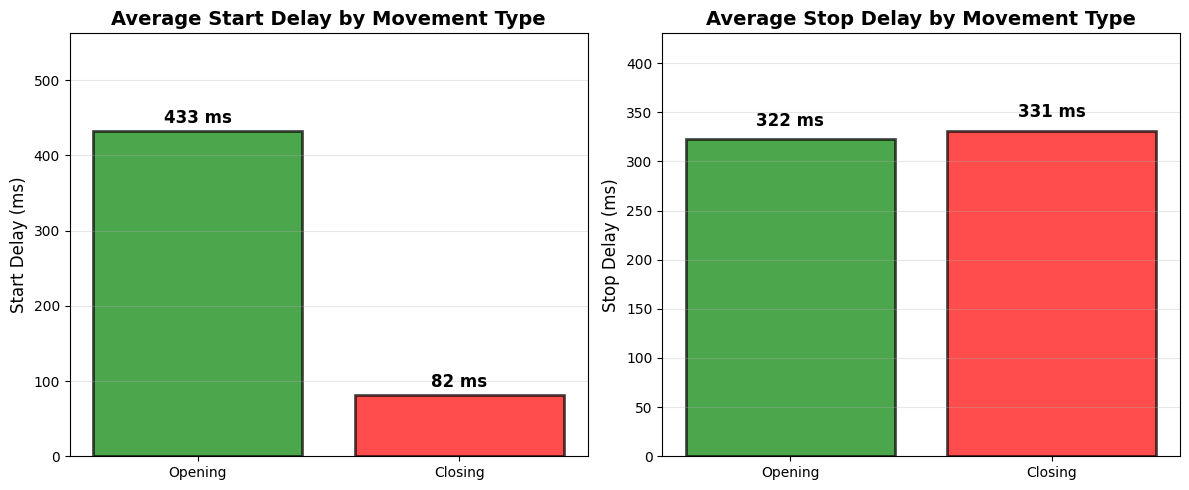

Delay Comparison:
----------------------------------------
Opening:
  Start delay: 433 ms
  Stop delay:  322 ms
  Total delay: 755 ms
Closing:
  Start delay: 82 ms
  Stop delay:  331 ms
  Total delay: 413 ms

Differences:
  Start delay difference: 351 ms
  Stop delay difference:  9 ms


In [7]:
# Compare start and stop delays between opening and closing movements
if analysis['statistics']:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Prepare data for start delays
    movement_types = []
    avg_start_delays = []
    avg_stop_delays = []
    colors = []
    
    for key, stats in analysis['statistics'].items():
        if 'opening' in key:
            movement_types.append('Opening')
            colors.append('green')
        elif 'closing' in key:
            movement_types.append('Closing')
            colors.append('red')
        else:
            continue
        avg_start_delays.append(stats.get('avg_start_delay_ms', 0))
        avg_stop_delays.append(stats['avg_stop_delay_ms'])
    
    if movement_types:
        # Plot start delays
        bars1 = ax1.bar(movement_types, avg_start_delays, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
        
        # Add value labels on bars
        for bar, val in zip(bars1, avg_start_delays):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
                   f'{val:.0f} ms', ha='center', va='bottom', fontsize=12, fontweight='bold')
        
        ax1.set_ylabel('Start Delay (ms)', fontsize=12)
        ax1.set_title('Average Start Delay by Movement Type', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3, axis='y')
        ax1.set_ylim(0, max(avg_start_delays) * 1.3 if avg_start_delays else 300)
        
        # Plot stop delays
        bars2 = ax2.bar(movement_types, avg_stop_delays, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
        
        # Add value labels on bars
        for bar, val in zip(bars2, avg_stop_delays):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 10,
                   f'{val:.0f} ms', ha='center', va='bottom', fontsize=12, fontweight='bold')
        
        ax2.set_ylabel('Stop Delay (ms)', fontsize=12)
        ax2.set_title('Average Stop Delay by Movement Type', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.set_ylim(0, max(avg_stop_delays) * 1.3 if avg_stop_delays else 500)
        
        plt.tight_layout()
        plt.show()
        
        # Print comparison
        print("Delay Comparison:")
        print("-" * 40)
        for i, movement in enumerate(movement_types):
            total_delay = avg_start_delays[i] + avg_stop_delays[i]
            print(f"{movement}:")
            print(f"  Start delay: {avg_start_delays[i]:.0f} ms")
            print(f"  Stop delay:  {avg_stop_delays[i]:.0f} ms")
            print(f"  Total delay: {total_delay:.0f} ms")
            
        if len(movement_types) == 2:
            start_diff = abs(avg_start_delays[0] - avg_start_delays[1])
            stop_diff = abs(avg_stop_delays[0] - avg_stop_delays[1])
            print(f"\nDifferences:")
            print(f"  Start delay difference: {start_diff:.0f} ms")
            print(f"  Stop delay difference:  {stop_diff:.0f} ms")

In [8]:
# Summary and insights
print("=" * 60)
print("ANALYSIS SUMMARY")
print("=" * 60)

print(f"\nDataset: {DATASET}")
print(f"Total sensor readings: {len(df)}")
print(f"Total events: {len(ha_events)}")

if analysis['results']:
    print(f"Movement sequences analyzed: {len(analysis['results'])}")
    
    # Group by movement type
    opening_results = [r for r in analysis['results'] if r.movement_type == 'opening']
    closing_results = [r for r in analysis['results'] if r.movement_type == 'closing']
    
    if opening_results:
        print(f"\nOpening movements: {len(opening_results)}")
        avg_delay = np.mean([r.stop_delay_ms for r in opening_results])
        avg_overrun = np.mean([r.overrun_after_stop for r in opening_results])
        print(f"  Average stop delay: {avg_delay:.0f} ms")
        print(f"  Average overrun: {avg_overrun:.3f} rad")
    
    if closing_results:
        print(f"\nClosing movements: {len(closing_results)}")
        avg_delay = np.mean([r.stop_delay_ms for r in closing_results])
        avg_overrun = np.mean([r.overrun_after_stop for r in closing_results])
        print(f"  Average stop delay: {avg_delay:.0f} ms")
        print(f"  Average overrun: {avg_overrun:.3f} rad")
    
    print("\nKey Findings:")
    print("• Stop delay is measured from stop command to actual movement cessation")
    print("• Overrun is the additional movement after the stop command")
    print("• The yellow highlighted region in velocity plots shows the stop delay period")
    
print("\n" + "=" * 60)

ANALYSIS SUMMARY

Dataset: partial-movements.csv
Total sensor readings: 1260
Total events: 20
Movement sequences analyzed: 10

Opening movements: 5
  Average stop delay: 322 ms
  Average overrun: 0.014 rad

Closing movements: 5
  Average stop delay: 331 ms
  Average overrun: -0.012 rad

Key Findings:
• Stop delay is measured from stop command to actual movement cessation
• Overrun is the additional movement after the stop command
• The yellow highlighted region in velocity plots shows the stop delay period

